In [50]:
# Load packages and directories


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import os
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.subplots as sp
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import tslearn.clustering as tsc
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.cluster import KMeans
import sklearn.preprocessing as pr
import sklearn.metrics as mt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize, Normalizer
from datetime import datetime
from sklearn_extra.cluster import KMedoids
from tslearn.clustering import TimeSeriesKMeans
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
from sklearn_extra.cluster import KMedoids
import somoclu
import importlib
import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import euclidean
import importlib
import clustering_processing as cp, preprocessing as prep, cluster_grid
import somoclu

base_directory = "C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning"
data_directory = os.path.join(base_directory, 'edp_data')
cleaned_data_directory = os.path.join(base_directory, 'resampled_30min_data_cleaned')

# Directory containing the household profile CSV files
survey_data = pd.read_csv(os.path.join(base_directory, 'survey/edp_survey_cleaned.csv'))  
output_directory = os.path.join(base_directory, 'figures_for_paper')  # Change this to your output directory

climate_zone_descriptions = {
    1: 'High humidity summer, warm winter (Zone 1)',
    2: 'Warm humid summer, mild winter (Zone 2)',
    3: 'Hot dry summer, warm winter (Zone 3)',
    4: 'Hot dry summer, cool winter (Zone 4)',
    5: 'Warm temperate (Zone 5)',
    6: 'Mild temperate (Zone 6)',
    7: 'Cool temperate (Zone 7)',
    8: 'Alpine (Zone 8)'
}

survey_data['climate_zone'] = survey_data['climate_zone'].map(climate_zone_descriptions)

STEP 1: Create unnormalized combined dataframe of all sites annual profiles
STEP 2: Create low consumption dict (keys are each date, values are list of sites which have low consumption profile on that day)

In [77]:

importlib.reload(prep)
date_range = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:30:00', freq='30T')
combined_df_unnormalized = prep.create_combined_df_UNNORMALIZED(cleaned_data_directory, date_range)
combined_df_normalized = prep.create_combined_df(cleaned_data_directory, date_range)

In [59]:
# Pre-bin the "baseline" group with inputted thresholds for low consumption and create the dictionary for low consumption values.
# values were justified in other_investigations/parameter_sweep
importlib.reload(prep)
min_cons = 0.025 # Threshold is standby power is 50W = 0.025 kwh per half hour
low_consumption_dict = prep.create_low_consumption_dict(combined_df_unnormalized, min_cons=min_cons)


In [81]:
importlib.reload(prep)
min_cons = 0.025
low_consumption_dict_normalized = prep.create_low_consumption_dict(combined_df_normalized, min_cons=min_cons)

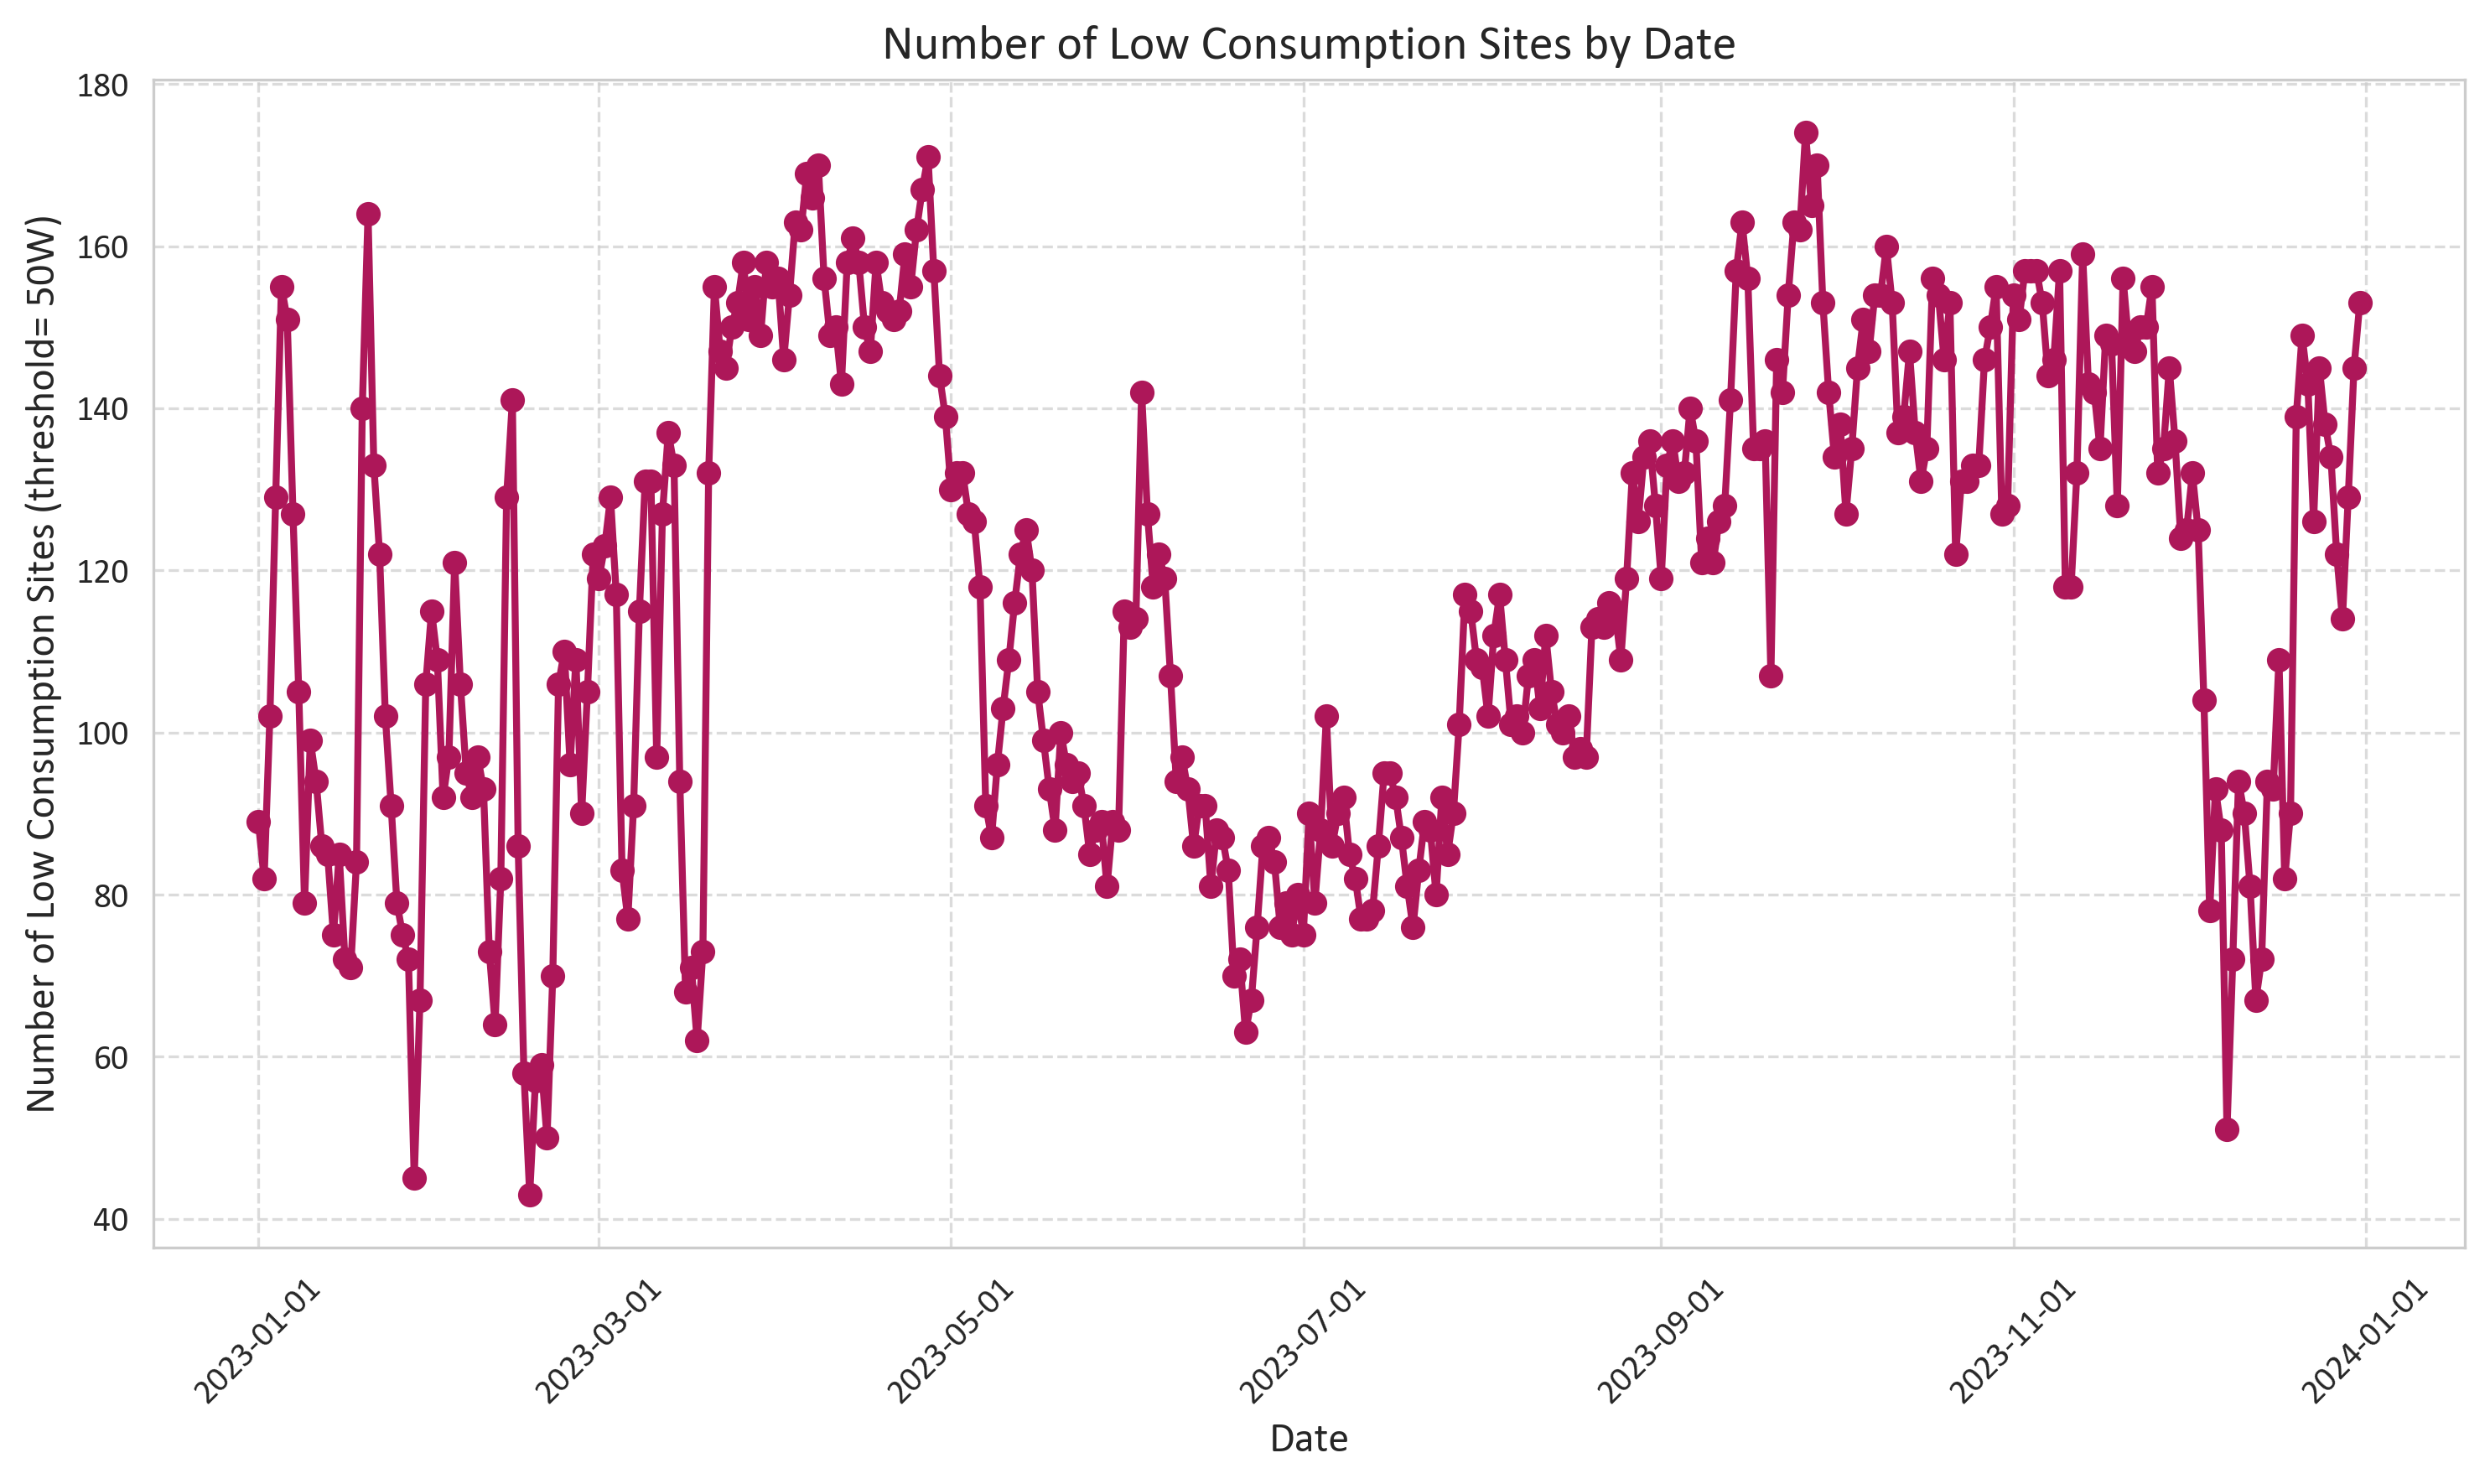

In [82]:
# Visualize Low Consumptions by Date 
# Extract dates and lengths into separate lists
dates = list(low_consumption_dict_normalized.keys())
num_sites = [len(sites) for sites in low_consumption_dict_normalized.values()]

# Set preferred style, font, and color palette
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Calibri"

# Create the plot
plt.figure(figsize=(10, 6), dpi = 300)
plt.plot(dates, num_sites, marker='o', linestyle='-', linewidth=2, color=sns.color_palette("rocket")[2])

# Customize the plot
plt.title('Number of Low Consumption Sites by Date', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Low Consumption Sites (threshold= 50W)', fontsize=12)

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()


# save figure to output directory
plt.savefig(os.path.join(output_directory, 'low_consumption_sites_by_date.png'), dpi=300, format = "png")


# Show the plot
plt.show()

In [119]:
# Create min-max scaled combined dataframe with half-hourly timestamps from 01/01/2023-12/31/2023 as rows and site IDs as columns
# Site IDs with no air con or net load data were removed, Site IDs which had 
importlib.reload(prep)

# Create a complete date range for 2023 in 30-minute increments
date_range = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:30:00', freq='30T')

#combined_df = prep.create_combined_df(cleaned_data_directory, date_range)
# TRAINING DF AND TESTING DF ARE MIN MAX NORMALIZED
training_df, testing_df = prep.create_train_test_combined_df(cleaned_data_directory, date_range)


In [161]:
def find_filtered_site_df(X, low_consumption_dict, site_id, feature_weights):
    """
    Filter and prepare data for a specific site_id, removing dates with low consumption
    
    Parameters:
    X (DataFrame): DataFrame with dates as index and a column for the specific site_id
    low_consumption_dict (dict): Dictionary with dates as keys and lists of site_ids to remove as values
    site_id (str): The site ID being processed
    feature_weights (dict): Weights for raw profile and summary statistics
    
    Returns:
    DataFrame: Filtered data for the site_id
    """
    if feature_weights is None:
        feature_weights = {
            'raw_profile': 1,
            'summary_stats': 0
        }
    
    # Create a copy to avoid modifying the original
    X_filtered = X.copy()
    # print X_filtered index type
    # Find dates where this site_id is in the low consumption list
    dates_to_remove = []
    for date, sites in low_consumption_dict.items():
        if site_id in sites:
            dates_to_remove.append(date)
    # print dates_to_remove type

    if dates_to_remove:
        # Convert string dates to datetime for comparison if needed        
        # Remove dates where this site has low consumption
        dates_found = [date for date in dates_to_remove if date in X_filtered.index]
        if dates_found:
            # print(f"Removing {len(dates_found)} low consumption dates for site {site_id}")
            X_filtered = X_filtered.drop(index=dates_found)
        else:
            print(f"No dates to remove for site {site_id}")
    else:
        print(f"No low consumption dates listed for site {site_id}")
    
    print(X_filtered.shape)
    # Each row is now a daily profile
    profiles = X_filtered
    
    features_list = []
    # iterate through each row (daily profile) in the dataframe
    for date_idx in profiles.index:
        profile = profiles.loc[date_idx].values
        features = cp.calculate_time_series_features_extensive(profile)
        features_list.append(features)
    
    # Convert features to array and scale
    features_df = pd.DataFrame(features_list, index=profiles.index)
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features_df)
    
    X_values = profiles.values
    # Combine scaled data using weights
    X_filtered_with_features = np.hstack([
        X_values * feature_weights['raw_profile'],
        features_scaled * feature_weights['summary_stats']
    ])
    
    X_filtered_with_features = pd.DataFrame(X_filtered_with_features, index=profiles.index)


    return X_filtered, X_filtered_with_features

# Helper function to calculate clustering metrics (unchanged)
def calculate_cluster_metrics(X, labels):
    """
    Calculate standard clustering evaluation metrics
    
    Parameters:
    X (DataFrame or array): Data used for clustering
    labels (array): Cluster labels assigned to each data point
    
    Returns:
    tuple: (silhouette score, davies-bouldin score, MIA score, combined index)
    """
    try:
        sil_score = silhouette_score(X, labels)
        dbi_score = davies_bouldin_score(X, labels)
        mia_score = cluster_grid.mean_index_adequacy(X, labels)
        combined_index = (dbi_score * mia_score) / sil_score if sil_score > 0 else float("Inf")  # Combined metric
        
        return sil_score, dbi_score, mia_score, combined_index
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return float('nan'), float('nan'), float('nan'), float('nan')
    
def evaluate_clusters_kmeans(X, site_id, low_consumption_dict, min_clusters=4, max_clusters=8, feature_weights=None):
    """
    Evaluate KMeans clustering for a specific site_id
    """

    sample_num = X.shape[0]  # Number of days for this site
    silhouette_scores = [] 
    dbi_scores = [] 
    mia_scores = []
    combined_indices = []
    all_results = []  # Store detailed results for each cluster attempt

    for n_clusters in range(min_clusters, max_clusters + 1): 
        try:
            kmeans = TimeSeriesKMeans(n_clusters=n_clusters, random_state=42) 
            labels = kmeans.fit_predict(X)
            
            # Calculate metrics using the helper function
            sil_score, dbi_score, mia_score, combined_index = calculate_cluster_metrics(X, labels)
            
            silhouette_scores.append(sil_score) 
            dbi_scores.append(dbi_score)
            mia_scores.append(mia_score)
            combined_indices.append(combined_index)
            
            # Store detailed results
            all_results.append({
                'SiteID': site_id,
                'NumClusters': n_clusters,
                'Method': 'KMeans',
                'Silhouette': sil_score,
                'DBI': dbi_score,
                'MIA': mia_score,
                'Combined_Index': combined_index,
                'IsOptimal': False  # Will be updated later
            })

        except Exception as e:
            print(f"Error with {n_clusters} KMeans clusters for site {site_id}: {e}")
            silhouette_scores.append(float('nan'))
            dbi_scores.append(float('nan'))
            mia_scores.append(float('nan'))
            combined_indices.append(float('nan'))
            
            # Store failed attempt
            all_results.append({
                'SiteID': site_id,
                'NumClusters': n_clusters,
                'Method': 'KMeans',
                'Silhouette': float('nan'),
                'DBI': float('nan'),
                'MIA': float('nan'),
                'Combined_Index': float('nan'),
                'IsOptimal': False
            })

    return silhouette_scores, dbi_scores, mia_scores, combined_indices, sample_num, all_results

def evaluate_clusters_kmedoids(X, site_id, low_consumption_dict, min_clusters=4, max_clusters=8, feature_weights=None):
    """
    Evaluate KMedoids clustering for a specific site_id
    """
    
    sample_num = X.shape[0]  # Number of days for this site
    silhouette_scores = [] 
    dbi_scores = [] 
    mia_scores = []
    combined_indices = []
    all_results = []  # Store detailed results for each cluster attempt

    for n_clusters in range(min_clusters, max_clusters + 1): 
        try:
            kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
            labels = kmedoids.fit_predict(X)
            
            # Calculate metrics using the helper function
            sil_score, dbi_score, mia_score, combined_index = calculate_cluster_metrics(X, labels)
            
            silhouette_scores.append(sil_score) 
            dbi_scores.append(dbi_score)
            mia_scores.append(mia_score)
            combined_indices.append(combined_index)
            
            # Store detailed results
            all_results.append({
                'SiteID': site_id,
                'NumClusters': n_clusters,
                'Method': 'KMedoids',
                'Silhouette': sil_score,
                'DBI': dbi_score,
                'MIA': mia_score,
                'Combined_Index': combined_index,
                'IsOptimal': False  # Will be updated later
            })

        except Exception as e:
            print(f"Error with {n_clusters} KMedoids clusters for site {site_id}: {e}")
            silhouette_scores.append(float('nan'))
            dbi_scores.append(float('nan'))
            mia_scores.append(float('nan'))
            combined_indices.append(float('nan'))
            
            # Store failed attempt
            all_results.append({
                'SiteID': site_id,
                'NumClusters': n_clusters,
                'Method': 'KMedoids',
                'Silhouette': float('nan'),
                'DBI': float('nan'),
                'MIA': float('nan'),
                'Combined_Index': float('nan'),
                'IsOptimal': False
            })

    return silhouette_scores, dbi_scores, mia_scores, combined_indices, sample_num, all_results

def evaluate_clusters_som(X, site_id, low_consumption_dict, min_clusters=4, max_clusters=8, feature_weights=None):
    """
    Evaluate SOM clustering for a specific site_id
    """
    
    sample_num = X.shape[0]  # Number of days for this site
    silhouette_scores = [] 
    dbi_scores = [] 
    mia_scores = []
    combined_indices = []
    all_results = []  # Store detailed results for each cluster attempt
    som_dim = None
    
    # Convert to numpy array for somoclu
    data = X.values
    
    # Calculate maximum allowable SOM dimension based on data size
    max_dim = int(np.sqrt(sample_num/12))
    
    # Choose SOM dimension
    som_dim = min(max(min_clusters, max_clusters//2), max_dim)
    
    if som_dim < 2:
        print(f"Sample size too small for SOM for site {site_id}. Using minimum dimension of 2.")
        som_dim = 2
    
    try:
        # Initialize and train SOM
        som = somoclu.Somoclu(som_dim, som_dim, compactsupport=False, maptype='planar')
        som.train(data)
        
        # Get BMUs for each data point
        bmus = som.bmus
        
        # Calculate natural clusters
        m = np.arange(0, som_dim*som_dim, 1).reshape(som_dim, som_dim)
        labels = [m[bmus[i][1], bmus[i][0]] for i in range(len(bmus))]
        labels = np.array(labels)
        
        # Count unique clusters
        natural_clusters = len(np.unique(labels))
        
        # Apply KMeans if too many natural clusters
        if natural_clusters > max_clusters:
            for n_clusters in range(min_clusters, max_clusters + 1):
                try:
                    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
                    som.cluster(algorithm=clusterer)
                    m = som.clusters
                    k_labels = [m[bmus[i][1], bmus[i][0]] for i in range(len(bmus))]
                    k_labels = np.array(k_labels)
                    
                    # Calculate metrics
                    sil_score, dbi_score, mia_score, combined_index = calculate_cluster_metrics(X, k_labels)
                    
                    silhouette_scores.append(sil_score)
                    dbi_scores.append(dbi_score)
                    mia_scores.append(mia_score)
                    combined_indices.append(combined_index)
                    
                    # Store detailed results
                    method_name = f"SOM_{som_dim}x{som_dim}"
                    all_results.append({
                        'SiteID': site_id,
                        'NumClusters': n_clusters,
                        'Method': method_name,
                        'Silhouette': sil_score,
                        'DBI': dbi_score,
                        'MIA': mia_score,
                        'Combined_Index': combined_index,
                        'IsOptimal': False  # Will be updated later
                    })
                    
                except Exception as e:
                    print(f"Error with {n_clusters} SOM+KMeans clusters for site {site_id}: {e}")
                    silhouette_scores.append(float('nan'))
                    dbi_scores.append(float('nan'))
                    mia_scores.append(float('nan'))
                    combined_indices.append(float('nan'))
                    
                    # Store failed attempt
                    method_name = f"SOM_{som_dim}x{som_dim}"
                    all_results.append({
                        'SiteID': site_id,
                        'NumClusters': n_clusters,
                        'Method': method_name,
                        'Silhouette': float('nan'),
                        'DBI': float('nan'),
                        'MIA': float('nan'),
                        'Combined_Index': float('nan'),
                        'IsOptimal': False
                    })
        else:
            # Use natural clustering
            try:
                sil_score, dbi_score, mia_score, combined_index = calculate_cluster_metrics(X, labels)
                
                # Store natural clusters result
                method_name = f"SOM_{som_dim}x{som_dim}_natural"
                all_results.append({
                    'SiteID': site_id,
                    'NumClusters': natural_clusters,
                    'Method': method_name,
                    'Silhouette': sil_score,
                    'DBI': dbi_score,
                    'MIA': mia_score,
                    'Combined_Index': combined_index,
                    'IsOptimal': False  # Will be updated later
                })
                
                # Fill all positions with the same score
                for i, n_clusters in enumerate(range(min_clusters, max_clusters + 1)):
                    silhouette_scores.append(sil_score)
                    dbi_scores.append(dbi_score)
                    mia_scores.append(mia_score)
                    combined_indices.append(combined_index)
                    
                    if n_clusters != natural_clusters:
                        # Store additional cluster options for comparison but mark them as non-natural
                        all_results.append({
                            'SiteID': site_id,
                            'NumClusters': n_clusters,
                            'Method': f"SOM_{som_dim}x{som_dim}",
                            'Silhouette': sil_score,
                            'DBI': dbi_score,
                            'MIA': mia_score,
                            'Combined_Index': combined_index,
                            'IsOptimal': False,
                            'Note': 'Natural clusters used regardless'
                        })
            except Exception as e:
                print(f"Error calculating metrics for natural SOM clusters for site {site_id}: {e}")
                for n_clusters in range(min_clusters, max_clusters + 1):
                    silhouette_scores.append(float('nan'))
                    dbi_scores.append(float('nan'))
                    mia_scores.append(float('nan'))
                    combined_indices.append(float('nan'))
                    
                    # Store failed attempt
                    method_name = f"SOM_{som_dim}x{som_dim}"
                    all_results.append({
                        'SiteID': site_id,
                        'NumClusters': n_clusters,
                        'Method': method_name,
                        'Silhouette': float('nan'),
                        'DBI': float('nan'),
                        'MIA': float('nan'),
                        'Combined_Index': float('nan'),
                        'IsOptimal': False
                    })
                    
    except Exception as e:
        print(f"Error in SOM clustering for site {site_id}: {e}")
        for n_clusters in range(min_clusters, max_clusters + 1):
            silhouette_scores.append(float('nan'))
            dbi_scores.append(float('nan'))
            mia_scores.append(float('nan'))
            combined_indices.append(float('nan'))
            
            # Store failed attempt
            method_name = "SOM_failed"
            all_results.append({
                'SiteID': site_id,
                'NumClusters': n_clusters,
                'Method': method_name,
                'Silhouette': float('nan'),
                'DBI': float('nan'),
                'MIA': float('nan'),
                'Combined_Index': float('nan'),
                'IsOptimal': False
            })

    return silhouette_scores, dbi_scores, mia_scores, combined_indices, sample_num, som_dim, natural_clusters, all_results

def optimize_clusters_for_site(site_df, site_id, low_consumption_dict, min_clusters=4, max_clusters=8):
    """
    Find optimal clustering for a specific site_id
    
    Parameters:
    site_df (DataFrame): DataFrame with dates as index and consumption data for the site
    site_id (str): Site ID being processed
    low_consumption_dict (dict): Dictionary of dates with low consumption sites
    min_clusters (int): Minimum number of clusters to try
    max_clusters (int): Maximum number of clusters to try
    
    Returns:
    tuple: Optimal clustering results and all clustering attempts
    """
    # Clean and prepare site data
    site_df_cleaned = site_df.interpolate(method='linear').dropna()
    
    if site_df_cleaned.shape[0] <= 1:
        print(f"Skipping clustering for site {site_id} due to insufficient data.")
        return None, []
    
    filtered_df, filtered_df_with_features = find_filtered_site_df(site_df_cleaned, low_consumption_dict, site_id, feature_weights=None)
    # convert values of filtered df to float32
    filtered_df = filtered_df.astype('float32')
    
    # Initialize list to store all clustering attempts
    all_clustering_attempts = []

    print("Evaluating kmeans for site", site_id)
    # KMeans clustering
    kmeans_result = evaluate_clusters_kmeans(
        filtered_df, site_id, low_consumption_dict, min_clusters, max_clusters, feature_weights=None
    )
    kmeans_silhouette, kmeans_dbi, kmeans_mia, kmeans_combined, sample_num, kmeans_all_results = kmeans_result
    all_clustering_attempts.extend(kmeans_all_results)
    
    print("Evaluating kmedoids for site", site_id)
    # KMedoids clustering
    kmedoids_result = evaluate_clusters_kmedoids(
        filtered_df, site_id, low_consumption_dict, min_clusters, max_clusters, feature_weights=None
    )
    kmedoids_silhouette, kmedoids_dbi, kmedoids_mia, kmedoids_combined, _, kmedoids_all_results = kmedoids_result
    all_clustering_attempts.extend(kmedoids_all_results)
    
    print("Evaluating SOM for site", site_id)
    # SOM clustering
    som_result = evaluate_clusters_som(
        filtered_df, site_id, low_consumption_dict, min_clusters, max_clusters, feature_weights=None
    )
    
    # Unpack SOM results
    if len(som_result) == 8:
        som_silhouette, som_dbi, som_mia, som_combined, _, som_dim, natural_clusters, som_all_results = som_result
        all_clustering_attempts.extend(som_all_results)
    else:
        som_silhouette, som_dbi, som_mia, som_combined, _ = som_result
        som_dim = None
        natural_clusters = None
        som_all_results = []
    
    # Find optimal number of clusters for each method
    kmeans_optimal_idx = np.nanargmin(kmeans_combined) if not all(np.isnan(kmeans_combined)) else -1
    kmedoids_optimal_idx = np.nanargmin(kmedoids_combined) if not all(np.isnan(kmedoids_combined)) else -1
    som_optimal_idx = np.nanargmin(som_combined) if not all(np.isnan(som_combined)) else -1
    
    # If all methods failed, return default values
    if kmeans_optimal_idx == -1 and kmedoids_optimal_idx == -1 and som_optimal_idx == -1:
        print(f"All clustering methods failed for site {site_id}")
        return (1, float('inf'), float('nan'), float('nan'), float('nan'), 0, "Failed"), all_clustering_attempts
    
    # Initialize variables for best method
    best_method = None
    best_score = float('inf')
    best_clusters = None
    best_silhouette = None
    best_dbi = None
    best_mia = None
    best_idx = None
    best_method_name = None
    
    # Check KMeans results
    if kmeans_optimal_idx != -1:
        score = kmeans_combined[kmeans_optimal_idx]
        if not np.isnan(score) and score < best_score:
            best_method = "KMeans"
            best_score = score
            best_clusters = kmeans_optimal_idx + min_clusters
            best_silhouette = kmeans_silhouette[kmeans_optimal_idx]
            best_dbi = kmeans_dbi[kmeans_optimal_idx]
            best_mia = kmeans_mia[kmeans_optimal_idx]
            best_idx = kmeans_optimal_idx
            best_method_name = "KMeans"
    
    # Check KMedoids results
    if kmedoids_optimal_idx != -1:
        score = kmedoids_combined[kmedoids_optimal_idx]
        if not np.isnan(score) and score < best_score:
            best_method = "KMedoids"
            best_score = score
            best_clusters = kmedoids_optimal_idx + min_clusters
            best_silhouette = kmedoids_silhouette[kmedoids_optimal_idx]
            best_dbi = kmedoids_dbi[kmedoids_optimal_idx]
            best_mia = kmedoids_mia[kmedoids_optimal_idx]
            best_idx = kmedoids_optimal_idx
            best_method_name = "KMedoids"
    
    # Check SOM results
    if som_optimal_idx != -1:
        score = som_combined[som_optimal_idx]
        if not np.isnan(score) and score < best_score:
            best_method = "SOM"
            best_score = score
            best_idx = som_optimal_idx
            if natural_clusters is not None and min_clusters <= natural_clusters <= max_clusters:
                best_clusters = natural_clusters
                best_method_name = f"SOM_{som_dim}x{som_dim}_natural"
            else:
                best_clusters = som_optimal_idx + min_clusters
                best_method_name = f"SOM_{som_dim}x{som_dim}"
            best_silhouette = som_silhouette[som_optimal_idx]
            best_dbi = som_dbi[som_optimal_idx]
            best_mia = som_mia[som_optimal_idx]
    
    # Mark the optimal clustering attempt
    for attempt in all_clustering_attempts:
        if (attempt['Method'] == best_method_name and 
            attempt['NumClusters'] == best_clusters):
            attempt['IsOptimal'] = True
    
    # Return best method results and all attempts
    if best_method is not None:
        if best_method == "SOM" and som_dim is not None:
            best_method = f"SOM_{som_dim}x{som_dim}"
            if natural_clusters is not None and min_clusters <= natural_clusters <= max_clusters:
                best_method += "_natural"
        return (best_clusters, best_score, best_silhouette, best_dbi, best_mia, sample_num, best_method), all_clustering_attempts
    else:
        return None, all_clustering_attempts

def main(df, low_consumption_dict):
    """
    Main function to process all sites
    
    Parameters:
    df (DataFrame): DataFrame with Timestamp and site consumption columns
    low_consumption_dict (dict): Dictionary of dates with low consumption sites
    
    Returns:
    tuple: (optimal_results_df, master_clustering_df)
    """
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Pivot the dataframe to get dates as rows and sites as columns
    df_pivoted = df.set_index('Timestamp')
    
    site_results = []
    all_clustering_attempts = []
    
    # Process each site
    for site_id in df_pivoted.columns:
        print(f"Processing site: {site_id}, data shape: {df_pivoted[site_id].shape}")
        
        # Get data for this site
        site_df = pd.DataFrame(df_pivoted[site_id])
        
        # Group by date to get daily profiles
        site_daily_df = {}
        for date, day_data in site_df.groupby(site_df.index.date):
            # Each day's data for this site becomes a row in the new dataframe
            site_daily_df[date] = day_data[site_id].values
        
        # Convert to DataFrame where each row is a daily profile for this site
        site_daily_df = pd.DataFrame.from_dict(site_daily_df, orient='index')
        
        # Find optimal clustering for this site
        optimal_result, site_clustering_attempts = optimize_clusters_for_site(
            site_daily_df, site_id, low_consumption_dict, min_clusters=4, max_clusters=8
        )
        
        if optimal_result is not None:
            (optimal_clusters, optimal_score, optimal_silhouette, 
                 optimal_dbi, optimal_mia, sample_num, optimal_method) = optimal_result
                
            site_results.append({
                'SiteID': site_id,
                'OptimalClusters': optimal_clusters,
                'Combined_Index': optimal_score,
                'Silhouette': optimal_silhouette,
                'DBI': optimal_dbi,
                'MIA': optimal_mia,
                'Total Number of Days': sample_num,
                'OptimalMethod': optimal_method
            })
            
            # Add all clustering attempts for this site to master list
            all_clustering_attempts.extend(site_clustering_attempts)
        
    # Create dataframes
    optimal_results_df = pd.DataFrame(site_results)
    master_clustering_df = pd.DataFrame(all_clustering_attempts)
    
    print("Site optimal clusters comparison processed.")
    print(f"Total clustering attempts recorded: {len(master_clustering_df)}")
    
    return optimal_results_df, master_clustering_df

# Example usage
optimal_clusters_by_site, master_clustering_df = main(training_df, low_consumption_dict_normalized)

Processing site: W0019, data shape: (17520,)
(54, 48)
Evaluating kmeans for site W0019
Evaluating kmedoids for site W0019
Evaluating SOM for site W0019
Processing site: W0346, data shape: (17520,)
(203, 48)
Evaluating kmeans for site W0346
Evaluating kmedoids for site W0346
Evaluating SOM for site W0346
Processing site: W0079, data shape: (17520,)
(309, 48)
Evaluating kmeans for site W0079
Evaluating kmedoids for site W0079
Evaluating SOM for site W0079
Processing site: W0144, data shape: (17520,)
(143, 48)
Evaluating kmeans for site W0144
Evaluating kmedoids for site W0144
Evaluating SOM for site W0144
Processing site: W0096, data shape: (17520,)
(280, 48)
Evaluating kmeans for site W0096
Evaluating kmedoids for site W0096
Evaluating SOM for site W0096
Processing site: W0200, data shape: (17520,)
(140, 48)
Evaluating kmeans for site W0200
Evaluating kmedoids for site W0200
Evaluating SOM for site W0200
Processing site: W0342, data shape: (17520,)
(60, 48)
Evaluating kmeans for site W0

In [162]:
#master_clustering_df.to_csv(os.path.join(base_directory, 'first_stage_master_clustering_df.csv'), index=False)

      Method  NumClusters  Combined_Index  Silhouette       DBI       MIA
0     KMeans            4        7.233655    0.250918  1.583266  0.879994
1     KMeans            5        7.484762    0.230823  1.586580  0.839012
2     KMeans            6        7.398713    0.224379  1.554798  0.803769
3     KMeans            7        7.380477    0.218813  1.530096  0.773006
4     KMeans            8        7.114148    0.212531  1.505041  0.742226
5   KMedoids            4       36.485613    0.122295  1.997516  0.878568
6   KMedoids            5       71.954712    0.111505  1.974166  0.826951
7   KMedoids            6       34.077174    0.100182  1.930279  0.795984
8   KMedoids            7       35.454640    0.098546  1.893185  0.774965
9   KMedoids            8       63.926713    0.091779  1.879187  0.748107
10       SOM            2        0.759544    0.197694  0.364137  0.412365
11       SOM            3        3.428071    0.180902  0.723998  0.856558
12       SOM            4        9.601

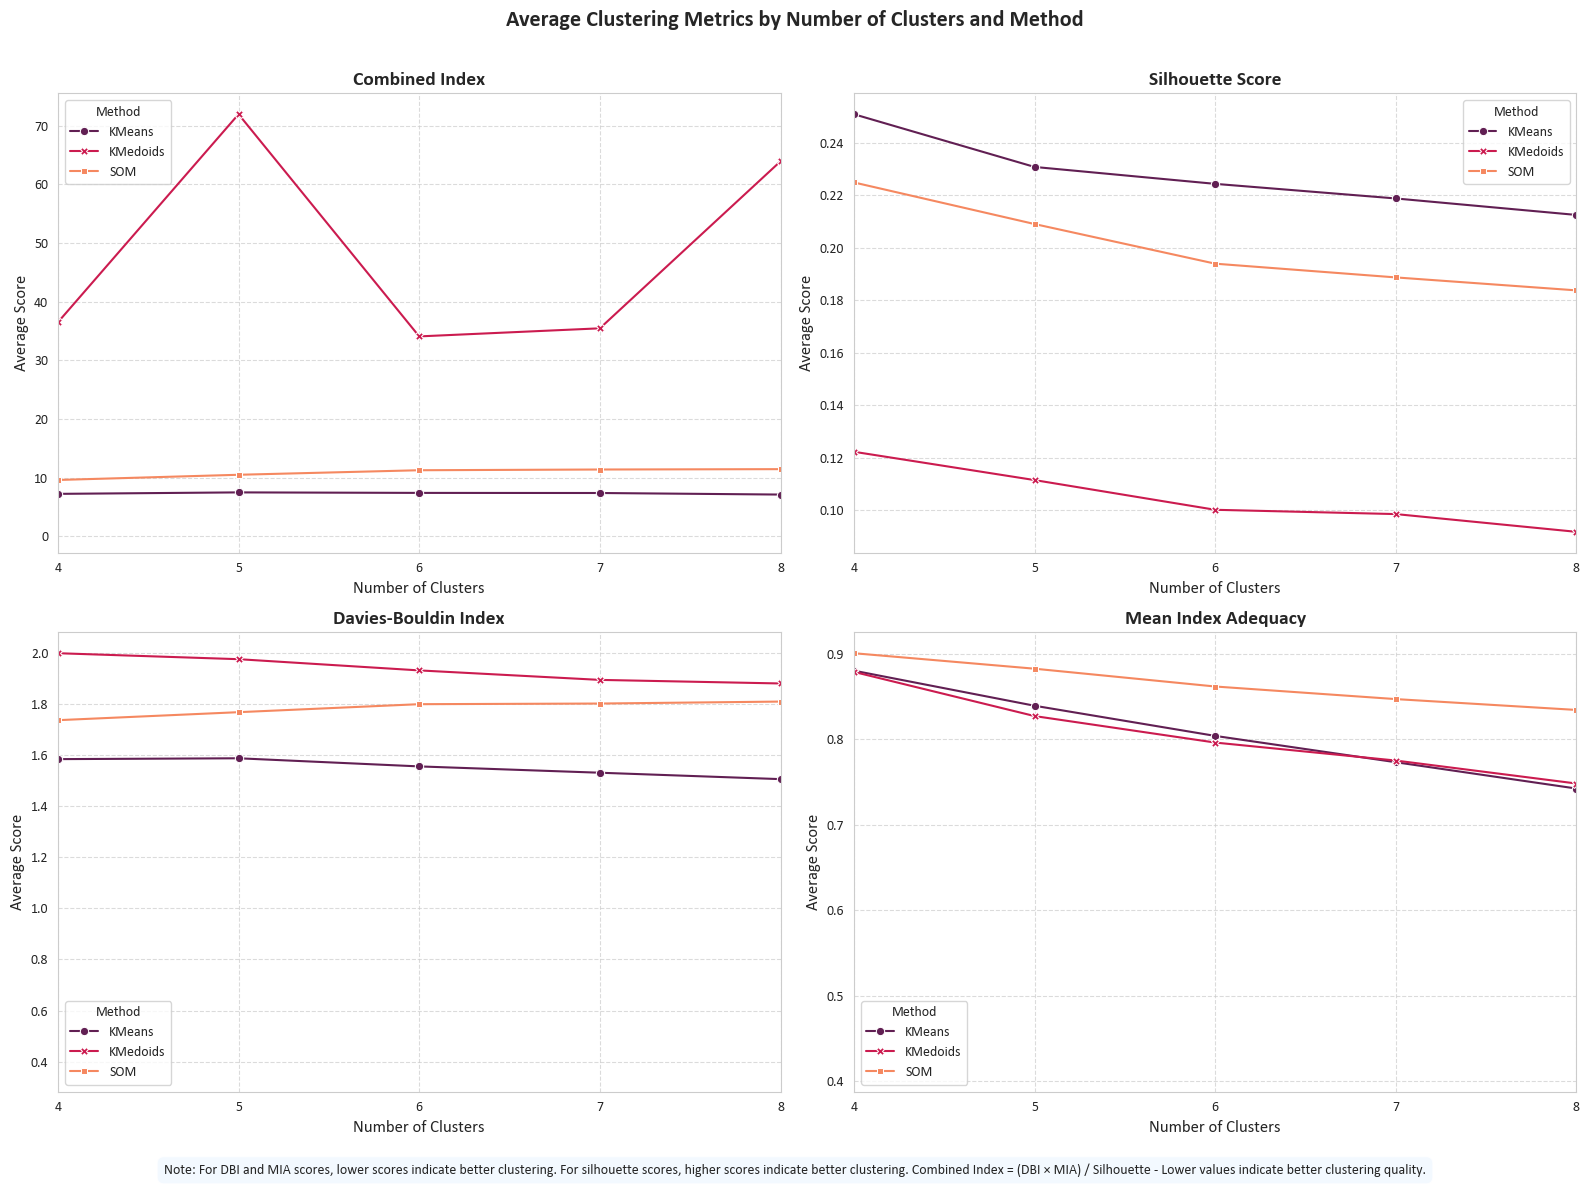

In [175]:


def plot_clustering_metrics(master_df):
    """
    Create line graphs of average metrics by cluster size faceted by method.
    
    Parameters:
    master_df (DataFrame): Master dataframe containing all clustering attempts
    """

    plt.rcParams['font.family'] = 'Calibri'

    # Process the data - combine all SOM variants
    master_df = master_df.copy()
    master_df['Method'] = master_df['Method'].apply(
        lambda x: 'SOM' if x.startswith('SOM') else x
    )
    
    # remove any rows with infinite values
    clean_df = master_df.replace(["inf"], np.nan).dropna(subset=['Combined_Index', 'Silhouette', 'DBI', 'MIA'])
    
    # drop rows where the Combined_Index is "inf"
    clean_df = clean_df[clean_df['Combined_Index'] != float('inf')]

    # Group by Method and NumClusters to calculate averages
    grouped_df = clean_df.groupby(['Method', 'NumClusters']).agg({
        'Combined_Index': 'mean',
        'Silhouette': 'mean',
        'DBI': 'mean',
        'MIA': 'mean'
    }).reset_index()
    
    print(grouped_df)
    # Set up the figure with subplots for each metric
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    metrics = {
        (0, 0): ('Combined_Index', 'Combined Index'),
        (0, 1): ('Silhouette', 'Silhouette Score'),
        (1, 0): ('DBI', 'Davies-Bouldin Index'),
        (1, 1): ('MIA', 'Mean Index Adequacy')
    }
    
    # Loop through each metric and create a line plot
    for pos, (metric, title) in metrics.items():
        ax = axs[pos]
        
        # Create line plot for this metric
        sns.lineplot(
            data=grouped_df,
            x='NumClusters',
            y=metric,
            hue='Method',
            style='Method',
            markers=True,
            dashes=False,
            palette='rocket',
            ax=ax
        )
        
        # Set plot titles and labels
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Number of Clusters', fontsize=12)
        ax.set_ylabel('Average Score', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        #set x axis to 4-8
        ax.set_xlim(4, 8)

        # only show integer ticks on x-axis
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

        # Add legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title='Method', fontsize=10)
    
    plt.suptitle('Average Clustering Metrics by Number of Clusters and Method', fontsize=16, fontweight='bold')
    
    # Add explanatory text at the bottom
    plt.figtext(0.5, 0.01, 
                'Note: For DBI and MIA scores, lower scores indicate better clustering. For silhouette scores, higher scores indicate better clustering. Combined Index = (DBI × MIA) / Silhouette - Lower values indicate better clustering quality.', 
                ha='center', fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8))
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    
    # Save the figure
    plt.savefig('clustering_metrics_comparison.png', dpi=300, bbox_inches='tight')
    
    # Display the figure
    plt.show()


plot_clustering_metrics(master_clustering_df)


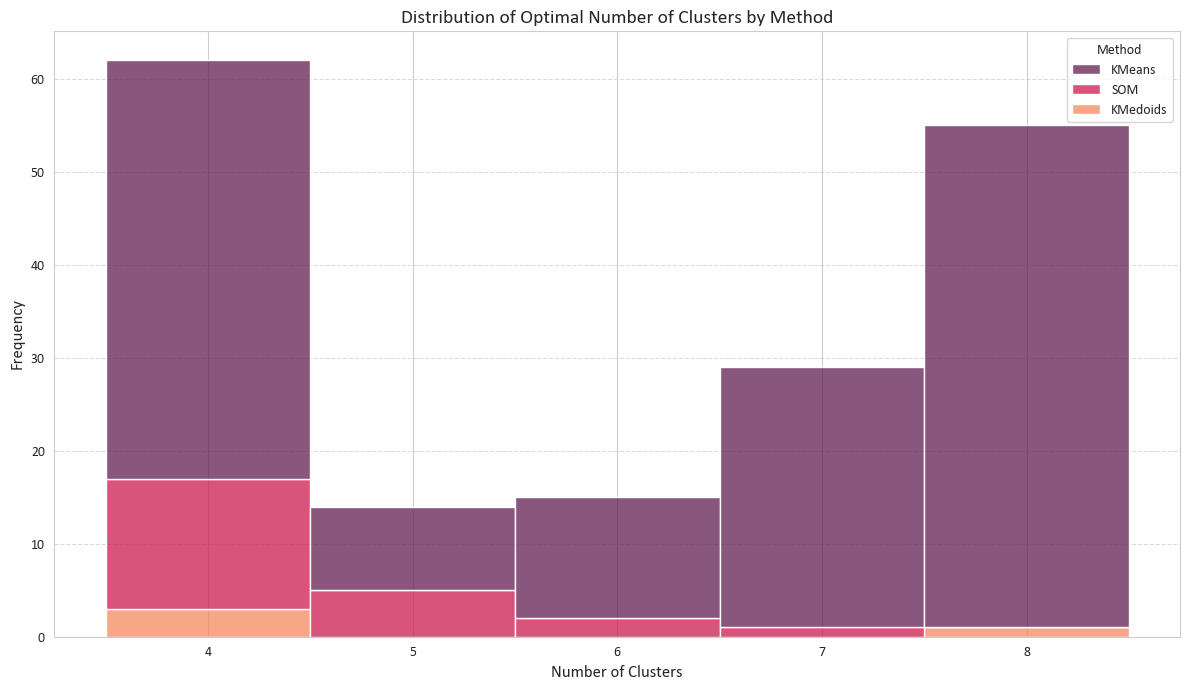

In [178]:
df = master_clustering_df.copy()
df['Method'] = df['Method'].apply(lambda x: 'SOM' if str(x).startswith('SOM') else x)

# Set the font to Calibri
plt.rcParams['font.family'] = 'Calibri'

# Assuming you already have your dataframe loaded as 'df'
# Filter for IsOptimal = True rows only
optimal_df = df[df['IsOptimal'] == True]

# Plot the histogram with color stacking by Method
plt.figure(figsize=(12, 7))
ax = sns.histplot(
    data=optimal_df, 
    x='NumClusters',
    hue='Method',
    multiple='stack',
    palette='rocket',
    bins=range(4, 10),
    discrete=True
)

plt.title('Distribution of Optimal Number of Clusters by Method Across Households', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(4, 9))
plt.grid(axis='y', linestyle='--', alpha=0.7)


# Adjust layout to make room for the legend
plt.tight_layout()
plt.show()

In [163]:
# count number of days where KMeans was optimal
kmeans_optimal = optimal_clusters_by_site[optimal_clusters_by_site['OptimalMethod'] == 'KMeans']
kmedoids_optimal = optimal_clusters_by_site[optimal_clusters_by_site['OptimalMethod'] == 'KMedoids']
# som was optimal for when optimalmethod starts with SOM
som_optimal = optimal_clusters_by_site[optimal_clusters_by_site['OptimalMethod'].str.startswith('SOM')]
print(f"KMeans was optimal for {kmeans_optimal.shape[0]} sites.")
print(f"KMedoids was optimal for {kmedoids_optimal.shape[0]} sites.")
print(f"SOM was optimal for {som_optimal.shape[0]} sites.")

KMeans was optimal for 149 sites.
KMedoids was optimal for 4 sites.
SOM was optimal for 22 sites.


In [125]:
optimal_clusters_by_site.to_csv(os.path.join(base_directory, 'optimal_clusters_by_site.csv'), index=False)

In [1]:
#Calculate the average number of clusters, average DBI, average MIA, and average Silhouette score for each method
kmeans_avg_clusters = kmeans_optimal['OptimalClusters'].mean()
kmeans_avg_dbi = kmeans_optimal['DBI'].mean().astype(float) # convert to float32
kmeans_avg_mia = kmeans_optimal['MIA'].mean()
kmeans_avg_silhouette = kmeans_optimal['Silhouette'].mean()
kmeans_avg_ci = kmeans_optimal['Combined_Index'].mean()
print(f"KMeans average clusters: {kmeans_avg_clusters}")
print(f"KMeans average DBI: {kmeans_avg_dbi}")
print(f"KMeans average MIA: {kmeans_avg_mia}")
print(f"KMeans average Silhouette: {kmeans_avg_silhouette}")
print(f"KMeans average Combined Index: {kmeans_avg_ci}")

NameError: name 'kmeans_optimal' is not defined

In [73]:

site_ids = optimal_clusters_by_site['SiteID'].unique()

In [ ]:
def process_multiple_sites(df, site_ids, optimal_clusters_by_site, low_consumption_dict, 
                          min_cluster_size=None, max_cluster_size=None, feature_weights=None):
    """
    Process multiple sites of data using enhanced clustering with both raw profiles and features.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing pre-scaled load profiles with 'Timestamp' column
    site_ids : list
        List of site IDs to process
    optimal_clusters_by_site : DataFrame
        DataFrame containing optimal number of clusters for each site
    low_consumption_dict : dict
        Dictionary of dates with low consumption sites
    min_cluster_size, max_cluster_size : int or None
        Minimum and maximum cluster sizes for constrained clustering
    feature_weights : dict, optional
        Dictionary of weights for different features (default: 0.7 for profiles, 0.3 for features)
    
    Returns:
    --------
    tuple: (rlp_dict, cluster_days_df)
        rlp_dict: Dictionary of representative load profiles
        cluster_days_df: DataFrame mapping days to clusters for each site
    """
    if feature_weights is None:
        feature_weights = {
            'raw_profile': 1,
            'summary_stats': 0
        }
    
    # Ensure datetime format for timestamps
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Pivot the dataframe to get dates as rows and sites as columns
    df_pivoted = df.set_index('Timestamp')
    
    rlp_dict = {}
    cluster_days_dict = {}

    for site_id in site_ids:
        print(f"Processing site: {site_id}")
        
        # Skip if site not in optimal clusters dataframe
        if site_id not in optimal_clusters_by_site['SiteID'].values:
            print(f"Site {site_id} not found in optimal clusters dataframe. Skipping.")
            continue
            
        # Get data for this site
        site_df = pd.DataFrame(df_pivoted[site_id])
        
        # Group by date to get daily profiles
        site_daily_df = {}
        for date, day_data in site_df.groupby(site_df.index.date):
            # Each day's data for this site becomes a row in the new dataframe
            site_daily_df[date] = day_data[site_id].values
        
        # Convert to DataFrame where each row is a daily profile for this site
        site_daily_df = pd.DataFrame.from_dict(site_daily_df, orient='index')
        
        # drop rows with NaN values
        site_daily_df = site_daily_df.dropna()
        
        # Get optimal number of clusters for this site
        num_clusters = optimal_clusters_by_site[optimal_clusters_by_site['SiteID'] == site_id]['OptimalClusters'].values[0]
        
        if pd.isna(num_clusters):
            print(f"No optimal cluster number found for site {site_id}. Skipping.")
            continue
            
        num_clusters = int(num_clusters)
        
        # Prepare data - filter and add features
        X_filtered, X_filtered_with_features = find_filtered_site_df(
            site_daily_df, low_consumption_dict, site_id, feature_weights
        )
        
        # Skip if not enough data points
        if X_filtered.shape[0] <= 0:
            print(f"Not enough data points for site {site_id}. Skipping.")
            continue
            
        # Check if we only have one optimal cluster
        if num_clusters == 1:
            # Skip k-means and treat all profiles as one cluster
            print(f"Site {site_id} has optimal cluster count of 1. Creating single cluster.")
            
            # Calculate the mean profile as the centroid
            mean_profile = X_filtered.mean(axis=0)
            
            # Calculate distances from each profile to the mean
            distances = []
            for i in range(len(X_filtered)):
                profile = X_filtered.iloc[i]
                distance = np.linalg.norm(profile - mean_profile)
                distances.append(distance)
            
            # Find the profile closest to the mean
            representative_idx = np.argmin(distances)
            representative_profile = X_filtered.iloc[representative_idx]
            
            # Store the RLP for this single cluster
            rlp_dict[f'{site_id}_C1'] = np.array(representative_profile)
            
            # Store all dates for this cluster
            cluster_days_dict[f'{site_id}_C1'] = X_filtered.index.tolist()
            
        else:
            # For sites with multiple clusters, proceed with k-means
            # Prepare clusterer    
            clusterer = TimeSeriesKMeans(n_clusters=num_clusters, random_state=42)
            
            # drop any rows with NaN values in X_filtered_with_features
            X_filtered = X_filtered.dropna()
            # Convert to numpy array for clustering if it's a DataFrame
            X_for_clustering = X_filtered.values if hasattr(X_filtered, 'values') else X_filtered
            
            labels = clusterer.fit_predict(X_for_clustering)
            
            # For each cluster, find the load profile closest to the centroid
            for cluster in range(num_clusters):
                # Get indices of days in this cluster
                cluster_mask = labels == cluster
                
                if np.sum(cluster_mask) > 0:  # Check if cluster is not empty
                    #cluster_profiles = X_filtered.iloc[cluster_mask]  # Daily profiles in this cluster
                    
                    # Get the centroid for this cluster
                    if hasattr(clusterer, 'cluster_centers_'):
                        centroid = clusterer.cluster_centers_[cluster]
                    else:
                        # For methods without centroids like KMedoids, calculate them manually
                        centroid = X_for_clustering[cluster_mask].mean(axis=0)
                    
                    # Calculate distances from each profile to the centroid
                    distances = []
                    for i, idx in enumerate(np.where(cluster_mask)[0]):
                        # Get the features for this profile
                        profile_features = X_for_clustering[idx]
                        # Calculate Euclidean distance to centroid
                        distance = np.linalg.norm(profile_features - centroid)
                        distances.append(distance)
                    
                    # Find the index of the profile closest to centroid
                    if distances:
                        closest_profile_idx = np.argmin(distances)
                        
                        # Get indices of samples in this cluster
                        cluster_indices = np.where(cluster_mask)[0]
                        
                        # Get the actual load profile closest to centroid
                        rlp_idx = cluster_indices[closest_profile_idx]
                        rlp = X_filtered.iloc[rlp_idx]
                        
                        # Store RLP in dictionary
                        rlp_dict[f'{site_id}_C{cluster+1}'] = np.array(rlp)
                        
                        # Store dates for this cluster
                        cluster_dates = np.array(X_filtered.index)[cluster_mask].tolist()
                        cluster_days_dict[f'{site_id}_C{cluster+1}'] = cluster_dates
        
        # Handle the low consumption days for this site
        low_consumption_days = []
        for date, sites in low_consumption_dict.items():
            if site_id in sites:
                low_consumption_days.append(date)
                
        if low_consumption_days:
            
            # Filter only dates that exist in the data
            days_found = [date for date in low_consumption_days if date in site_daily_df.index]
            
            if days_found:
                low_consumption_df = site_daily_df.loc[days_found]
                
                if not low_consumption_df.empty:
                    # Find the most representative low consumption profile
                    mean_profile = low_consumption_df.mean(axis=0).values
                    distances = []
                    
                    for i in range(len(low_consumption_df)):
                        profile = low_consumption_df.iloc[i].values
                        distance = np.linalg.norm(profile - mean_profile)
                        distances.append(distance)
                    
                    if distances:
                        # Find the most representative profile (closest to mean)
                        representative_idx = np.argmin(distances)
                        low_consumption_rlp = low_consumption_df.iloc[representative_idx]
                        
                        # Store the RLP for the low consumption days as cluster 0
                        rlp_dict[f'{site_id}_C0'] = np.array(low_consumption_rlp)
                        cluster_days_dict[f'{site_id}_C0'] = days_found

    # Convert results to DataFrames
    cluster_days_df = pd.DataFrame.from_dict(cluster_days_dict, orient='index')
    cluster_days_df.index.name = 'Site_Cluster'
    
    # Handle empty dataframe case
    if cluster_days_df.empty:
        print("No clusters were created. Check your input data and parameters.")
        return rlp_dict, pd.DataFrame(columns=['Site_Cluster', 'date'])
    
    # Melt the dataframe to get one row per date
    cluster_days_df = cluster_days_df.reset_index().melt(
        id_vars=['Site_Cluster'],
        var_name='temp',
        value_name='date'
    ).sort_values(by="Site_Cluster")
    
    # Clean up the dataframe
    cluster_days_df = cluster_days_df.dropna(subset=['date']).drop('temp', axis=1)
    cluster_days_df = cluster_days_df.reset_index(drop=True)
    
    return rlp_dict, cluster_days_df

# Example usage
rlp_dict, cluster_days_df = process_multiple_sites(
    training_df, 
    site_ids, 
    optimal_clusters_by_site, 
    low_consumption_dict
)

Processing site: W0019
(54, 48)
Processing site: W0346
(203, 48)
Processing site: W0079
(309, 48)
Processing site: W0144
(143, 48)
Processing site: W0096
(280, 48)
Processing site: W0200
(140, 48)
Processing site: W0342
(60, 48)
Processing site: S0372
(171, 48)
Processing site: S0268
(288, 48)
Processing site: W0272
(79, 48)
Processing site: W0141
(136, 48)
Processing site: S0309
(79, 48)
Processing site: S0245
(281, 48)
Processing site: W0006
(76, 48)
Processing site: W0321
(197, 48)
Processing site: S0576
(155, 48)
Processing site: W0005
(1, 48)
Site W0005 has optimal cluster count of 1. Creating single cluster.
Processing site: S0173
(107, 48)
Processing site: W0143
(59, 48)
Processing site: S0545
(137, 48)
Processing site: W0192
(253, 48)
Processing site: W0240
(43, 48)
Processing site: W0205
(93, 48)
Processing site: W0002
(163, 48)
Processing site: W0078
(135, 48)
Processing site: W0273
(149, 48)
Processing site: W0190
(200, 48)
Processing site: S0324
(238, 48)
Processing site: S

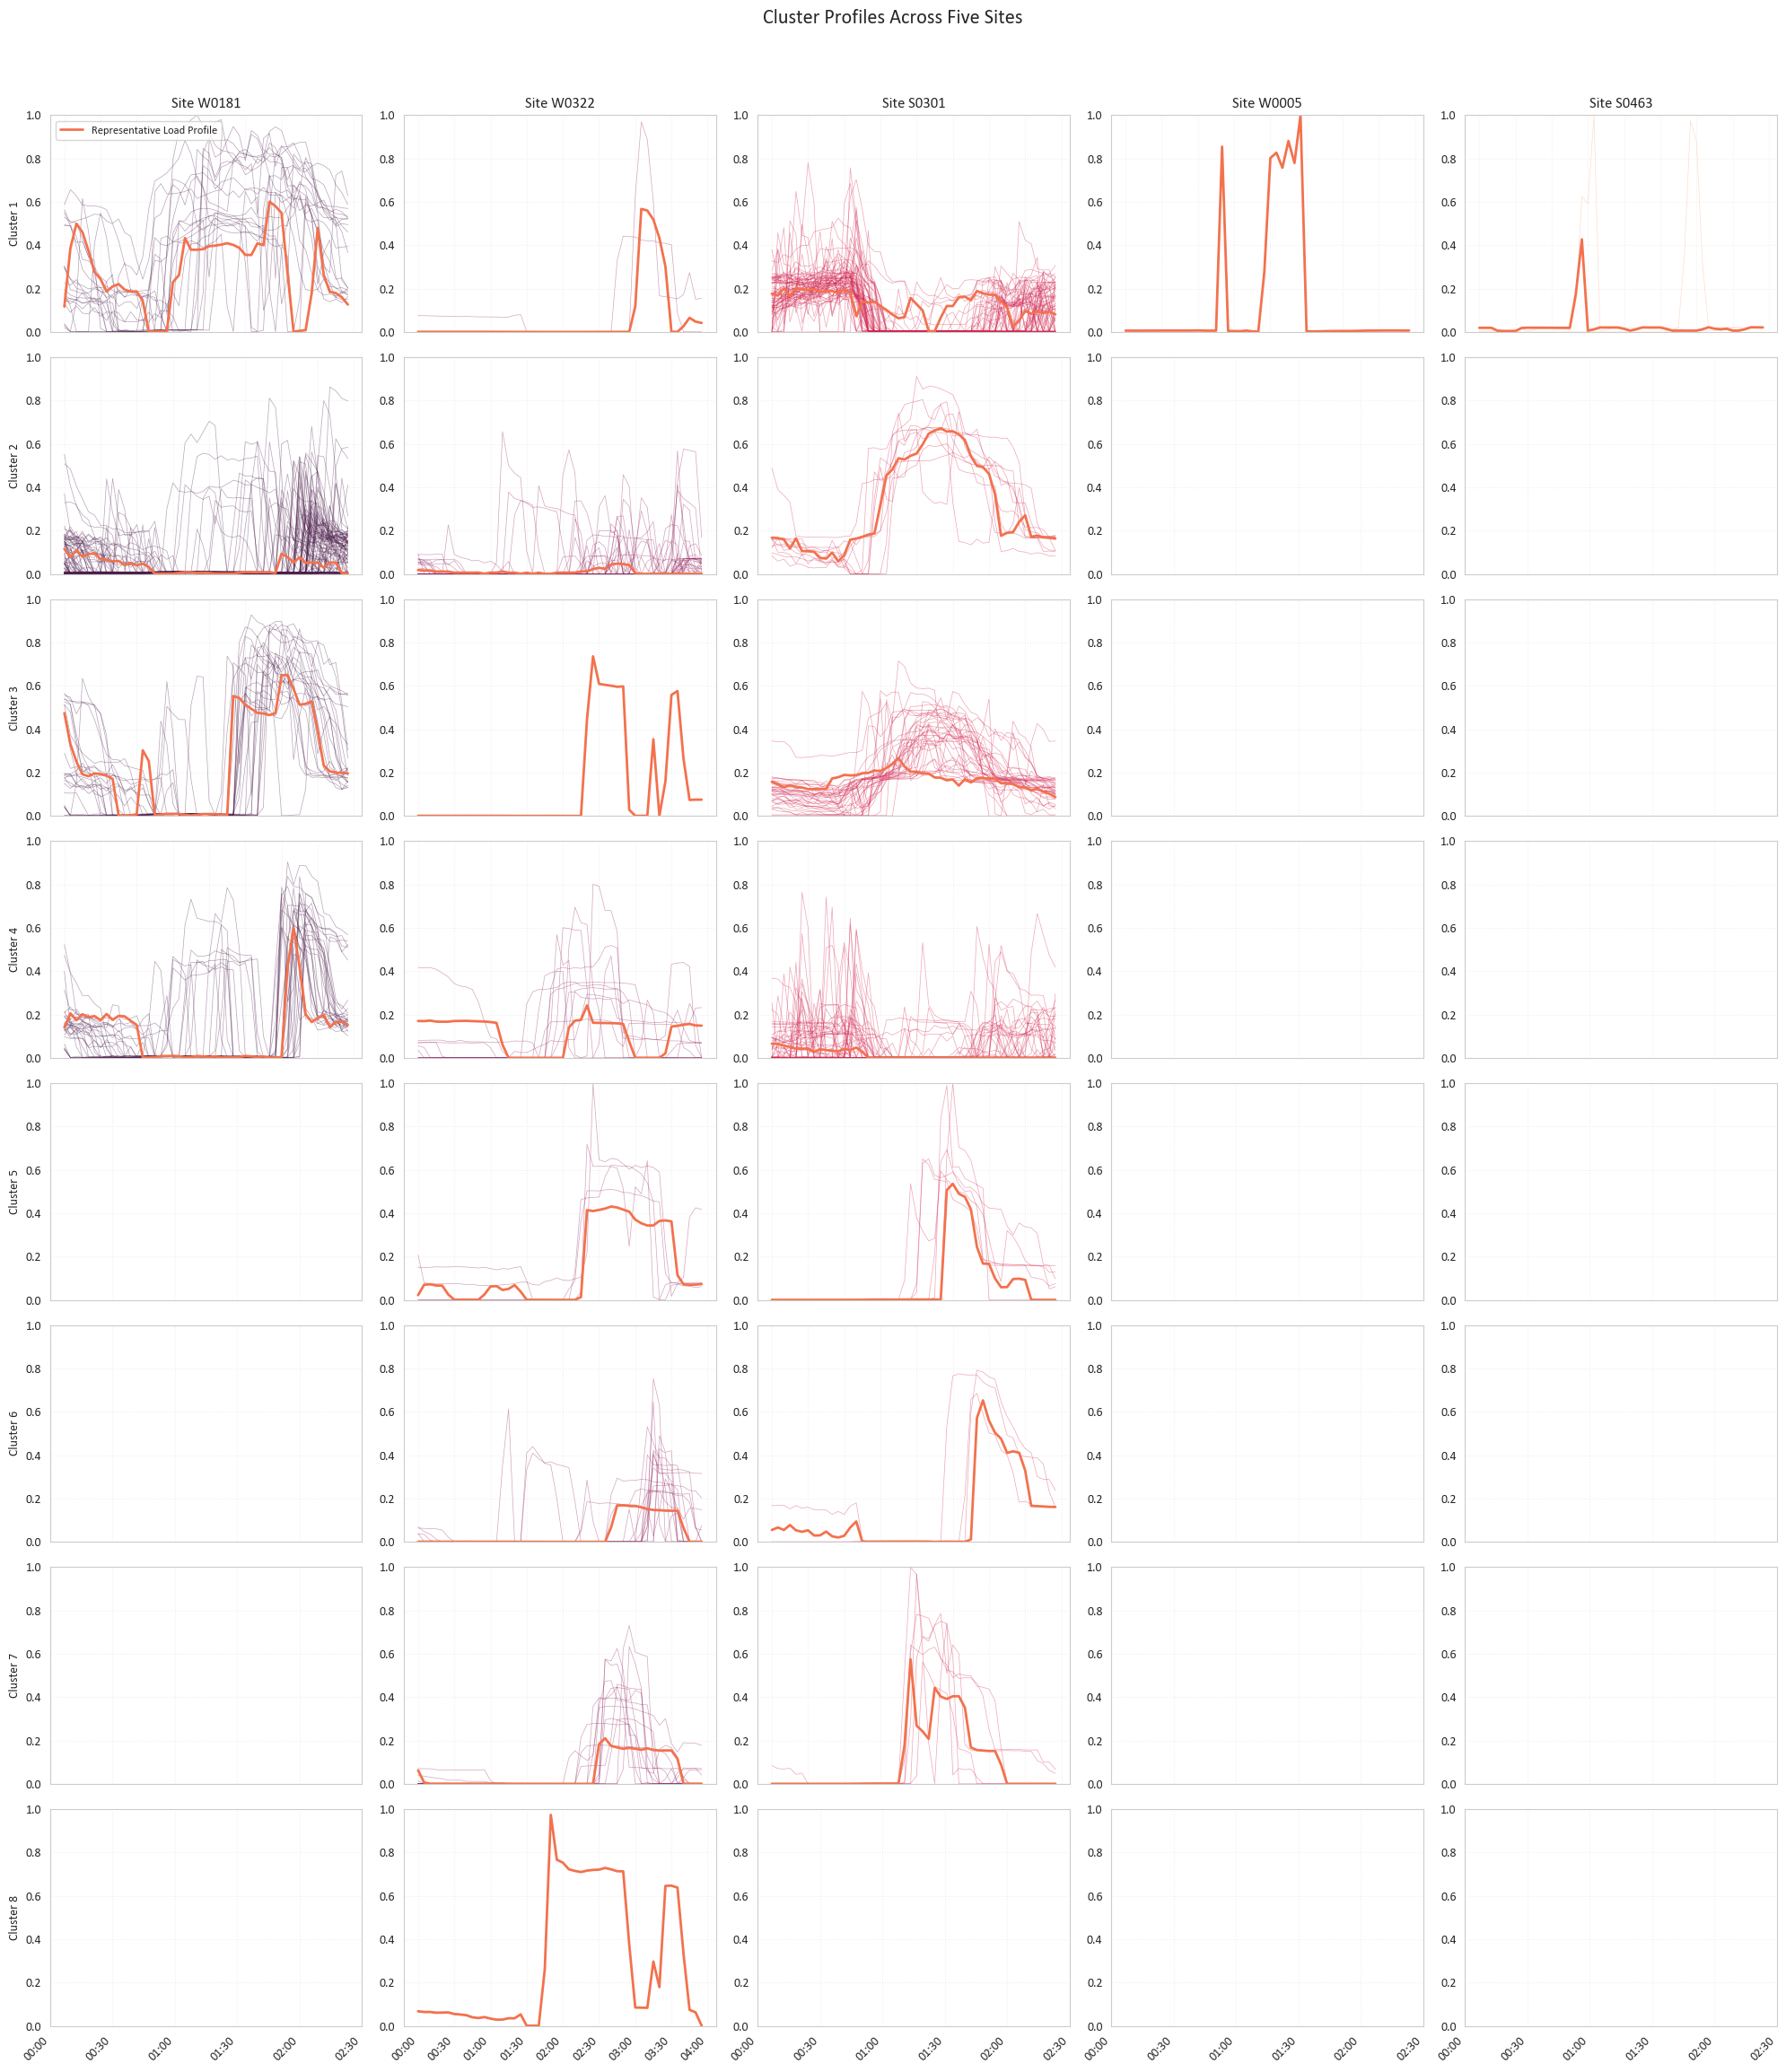

In [139]:

importlib.reload(cluster_grid)
num_clusters = 8
# Example usage:
# Example usage
fig, axes = cluster_grid.visualize_cluster_grid_sites(
    rlp_dict, 
    cluster_days_df, 
    training_df, 
    8,  # Number of clusters 
    selected_sites=['W0181', 'W0322', 'S0301', 'W0005', 'S0463']  # Example sites
)

plt.show()

In [142]:
print(cluster_days_df.head())

  Site_Cluster        date
0     S0083_C0  2023-10-20
1     S0083_C0  2023-09-21
2     S0083_C0  2023-02-22
3     S0083_C0  2023-06-06
4     S0083_C0  2023-08-12


In [147]:
#analyze cluster sizes
importlib.reload(cluster_grid)
# Example usage
result = cluster_grid.analyze_cluster_sizes_by_site(cluster_days_df, site_ids)

# Print summary statistics
print("Summary Statistics:")
for stat, value in result['summary_statistics'].items():
    print(f"{stat}: {value}")

Summary Statistics:
average_min_cluster_size: 9.039772727272727
average_max_cluster_size: 216.5
total_clusters_with_1_site: 121
total_clusters_with_2_sites: 51
total_sites_analyzed: 176


In [149]:
importlib.reload(cluster_grid)
rlp_aggregated = cluster_grid.aggregate_rlps(rlp_dict)

In [150]:
print(rlp_aggregated.head(2))

       W0019_C1  W0019_C2  W0019_C3  W0019_C4  W0019_C5  W0019_C6  W0019_C7  W0019_C8  W0019_C0  W0346_C1  W0346_C2  W0346_C3  W0346_C4  W0346_C5  W0346_C6  W0346_C7  W0346_C8  W0346_C0  W0079_C1  W0079_C2  W0079_C3  W0079_C4  W0079_C0  W0144_C1  W0144_C2  W0144_C3  W0144_C4  W0144_C5  W0144_C6  W0144_C7  W0144_C0  W0096_C1  W0096_C2  W0096_C3  W0096_C4  W0096_C0  W0200_C1  W0200_C2  W0200_C3  W0200_C4  W0200_C0  W0342_C1  W0342_C2  W0342_C3  W0342_C4  W0342_C5  W0342_C6  W0342_C7  W0342_C8  W0342_C0  ...  S0249_C3  S0249_C4  S0249_C5  S0249_C6  S0249_C0  W0276_C1  W0276_C2  W0276_C3  W0276_C4  W0276_C5  W0276_C6  W0276_C7  W0276_C0  W0009_C1  W0009_C2  W0009_C3  W0009_C4  W0009_C5  W0009_C0  W0069_C1  W0069_C2  W0069_C3  W0069_C4  W0069_C0  S0227_C1  S0227_C2  S0227_C3  S0227_C4  S0227_C5  S0227_C0  W0047_C1  W0047_C2  W0047_C3  W0047_C4  W0047_C5  W0047_C6  W0047_C7  W0047_C0  W0253_C1  W0253_C2  W0253_C3  W0253_C4  W0253_C5  W0253_C6  W0253_C7  W0253_C0  W0060_C1  W0060_C2  \
00:00 

PROGRESS: 

So far, what we have are the clusters for each day and we have extracted the RLPs for each cluster in each day. 
Input going forward will be the RLPs. 

NEXT STEP:
0. Find the optimal number of clusters for the RLPs 
1. Clustering of the RLPs 
2. Determine if sub-clustering is necessary

In [158]:
# finding the best number of profile classes

importlib.reload(cp)

cluster_type = "kmeans"
min_clusters = 4
max_clusters = 10
cluster_results, best_clusters, Profile_Classes = cp.compare_cluster_sizes(rlp_aggregated, cluster_type, min_clusters, max_clusters, save_plots=False, plot_dir=None, size_max = None)
cp.print_cluster_comparison_report(cluster_results, best_clusters)



Evaluating 4 clusters...
Evaluating 5 clusters...
Evaluating 6 clusters...
Evaluating 7 clusters...
Evaluating 8 clusters...
Evaluating 9 clusters...
Evaluating 10 clusters...

=== Cluster Comparison Report ===

Metrics Summary:
--------------------------------------------------
    Silhouette Score  Davies-Bouldin Index  Mean Index Adequacy  Combined Index  Silhouette Rank  Davies-Bouldin Rank  MIA Rank  Combined Index Rank
4             0.2295                1.8414               1.4023         11.2493              2.0                  4.0       7.0                  4.0
5             0.2317                1.8332               1.3775         10.8988              1.0                  3.0       6.0                  2.0
6             0.2100                1.7414               1.2974         10.7568              3.0                  1.0       5.0                  1.0
7             0.2089                1.8495               1.2839         11.3686              4.0                  5.0       

In [44]:
#cluster_results.to_csv(os.path.join(base_directory, 'optimal_profile_class_number_results.csv'), index=True)

In [63]:
print(best_clusters['Combined Index'])

5


(<Figure size 1200x600 with 1 Axes>,
 <Axes: xlabel='Time of the Day', ylabel='Household Air Conditioner Electricity Consumption (Scaled)'>)

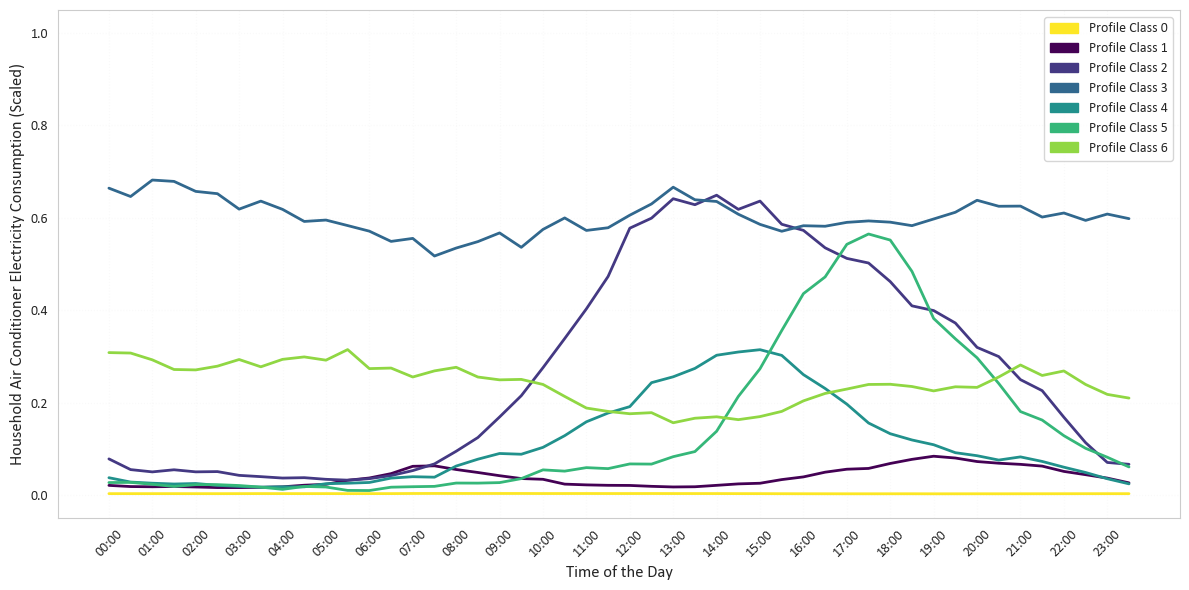

In [159]:
importlib.reload(cp)
cp.visualize_profile_classes(rlp_aggregated, Profile_Classes, best_clusters['Combined Index'])


Profile Class Sizes:
-------------------
Profile Class 0.0: 170 members
Profile Class 1.0: 527 members
Profile Class 2.0: 106 members
Profile Class 3.0: 24 members
Profile Class 4.0: 206 members
Profile Class 5.0: 115 members
Profile Class 6.0: 90 members


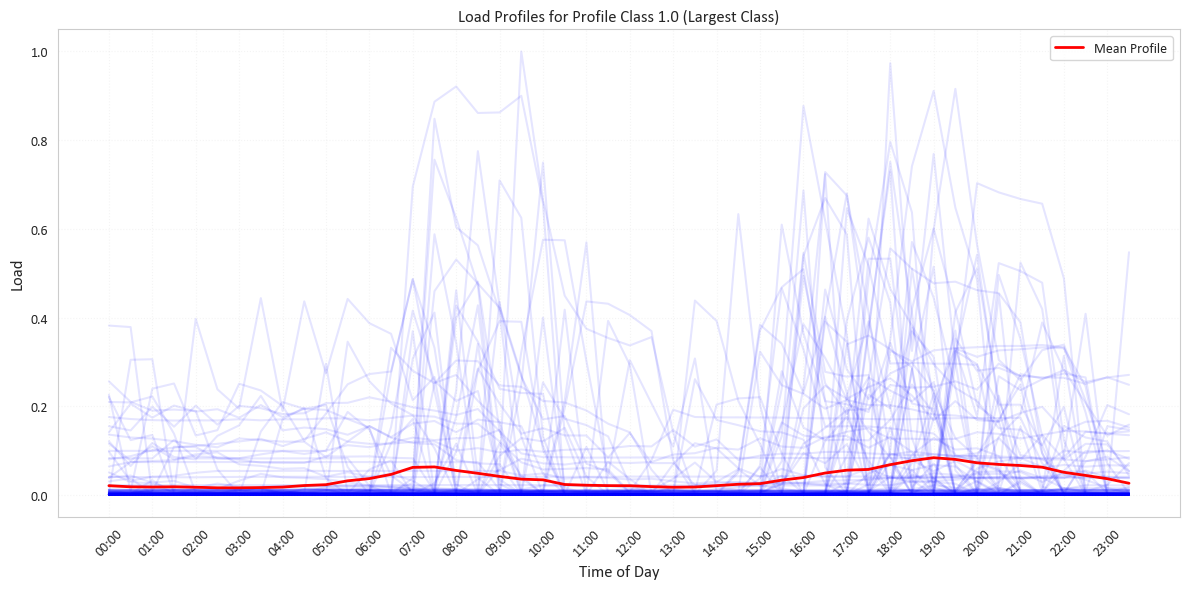

In [160]:
# Usage example:
importlib.reload(cp)
class_sizes, fig = cp.analyze_profile_classes(rlp_aggregated, Profile_Classes)
plt.show()

In [91]:
# Merging profile classes and cluster sites dataframes to get final assignments for each site on each day 
Profile_Classes.index.name = 'Date_Cluster' # set index name to match clusters 
date_range = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')

# drop sites from cluster_sites_df where site_ID is not in training_df columns
cluster_sites_df = cluster_sites_df[cluster_sites_df['site_ID'].isin(training_df.columns)]

# Merge the two dataframes
merged_df = pd.merge(cluster_sites_df, Profile_Classes.reset_index(), on='Date_Cluster')


# Function to extract date from Date_Cluster
def extract_date(date_cluster):
    return pd.to_datetime(date_cluster.split('_')[0]).date()

merged_df['Date'] = merged_df['Date_Cluster'].apply(extract_date)

merged_df = merged_df.drop(columns = 'Date_Cluster')

# Create the final dataframe
prelim_PC_assignments = pd.pivot_table(merged_df, values='Profile_Class', index='Date', columns='site_ID', aggfunc='first')
# Reindex with the full date range
prelim_PC_assignments = prelim_PC_assignments.reindex(date_range)

for i in prelim_PC_assignments.columns:      
    prelim_PC_assignments[[i]] = prelim_PC_assignments[[i]].astype('Int64')

print(prelim_PC_assignments)


site_ID     S0083  S0089  S0107  S0110  S0111  S0173  S0177  S0188  S0199  \
2023-01-01      1      0      3      3      0      1      0      1      0   
2023-01-02      0      0      3      0      0      0      0      3      0   
2023-01-03      0      0      0      5      1      0      0      3      3   
2023-01-04      1      0      0      0      1      1      0      1      1   
2023-01-05      1      0      0      0      1      1      1      0      0   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2023-12-27      1      0      0      0      0      0      0      3      3   
2023-12-28      0      0      0      0      1      0      0      3      3   
2023-12-29      0      0      0      0      1      0      0      3      1   
2023-12-30      0      0      0      0      0      0      0      4      0   
2023-12-31      0      0      0      0      1      1      1      5      1   

site_ID     S0208  ...  W0325  W0326  W0332  W0334  W0336  W0341  W0342  \


In [92]:
#if it doesn't exist already, export final_df


csv_path = 'prelim_profile_class_assignments.csv'
if not os.path.exists(csv_path):
    prelim_PC_assignments.to_csv(csv_path)
    print(f'File written: {csv_path}')
else:
    print('File already exists!')


File written: prelim_profile_class_assignments.csv


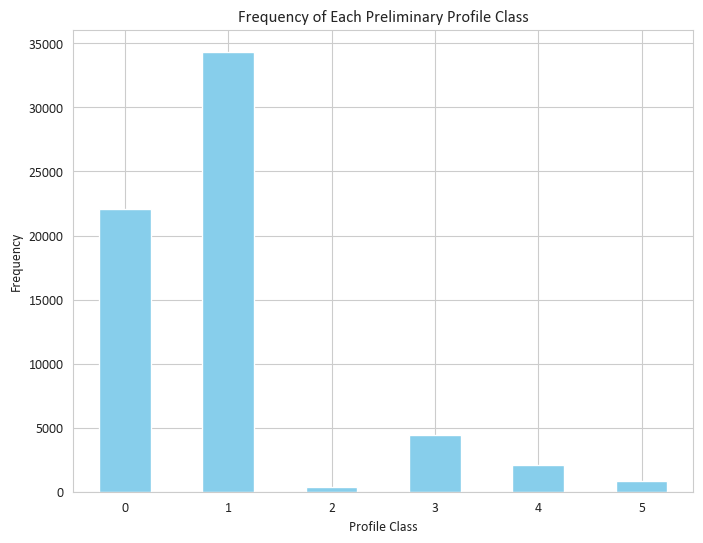

In [93]:
# Create figure of how many observations belong in each profile class 
frequency_counts = prelim_PC_assignments.values.flatten()

# Count the occurrences of each number (cluster label)
counts = pd.Series(frequency_counts).value_counts()

# Plot the frequency of each number
plt.figure(figsize=(8, 6))
counts.sort_index().plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Profile Class')
plt.ylabel('Frequency')
plt.title('Frequency of Each Preliminary Profile Class')
plt.xticks(rotation=0)
plt.show()

In [94]:
# merge cleaned survey with survey with station 
cleaned_survey = survey_data
survey_with_station = pd.read_csv(os.path.join(base_directory, 'survey/survey_with_station.csv'))
survey_raw = pd.read_csv(os.path.join(base_directory, 'survey/edp_survey_raw.csv'))
# merge weather station number from survey_with_station to cleaned_survey by site_ID
cleaned_survey = cleaned_survey.merge(survey_with_station[['edp_site_id', 'weather_station_number']], on='edp_site_id', how='left')
cleaned_survey = cleaned_survey.merge(survey_raw[['edp_site_id', 'num_rooms_aircon']], on='edp_site_id', how='left')
#cleaned_survey.to_csv(os.path.join(base_directory, 'survey/edp_survey_cleaned_w_stations.csv'), index=False)
# had to go and then manually clean values for num_rooms_aircon

In [95]:
cleaned_survey = pd.read_csv(os.path.join(base_directory, 'survey/edp_survey_cleaned_w_stations.csv'))
# print unique num_rooms_aircon values of cleaned_survey
print(cleaned_survey['num_rooms_aircon'].unique())

[ 1  8  7  2  6  3  4  5  9 11 12 10]


In [97]:


importlib.reload(cp)

survey_df = pd.read_csv(os.path.join(base_directory, 'survey/edp_survey_cleaned_w_stations.csv'))  # Change this to your output directory
survey_df.rename(columns={'edp_site_id': 'site_ID'}, inplace=True)

weather_folder_path = os.path.join(base_directory, 'weather/bom_data_max_min')  # Change this to your output directory
# Run the merger
result_df, incomplete_stations = cp.merge_site_weather_data(prelim_PC_assignments, survey_df, weather_folder_path)

print(incomplete_stations)

# if it doesn't exist already, export to csv

csv_path = 'df_for_regression_training_weather.csv'
if not os.path.exists(csv_path):
    result_df.to_csv(csv_path)
    print(f'File written: {csv_path}')
else:
    print('File already exists!')



{}
File written: df_for_regression_training_weather.csv


Final Outputs from this script:
- df_for_regression_training_weather.csv
- prelim_profile_class_assignments.csv
Next Step is to go to the Sub-Clustering Script 